In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#leer el data
data = pd.read_csv('octavos_df.csv')
data.head()

,Equipo 1,Equipo 2,Temporada,goles_1,goles_2,goles_ida_1,goles_ida_2,goles_vuelta_2,goles_vuelta_1
0,Leipzig,Manchester City,22/23,1,8,1,1,0,7
1,Brujas,Benfica,22/23,1,7,0,2,1,5
2,Liverpool,Real Madrid,22/23,2,6,2,5,0,1
3,Milan,Tottenham Hotspur,22/23,1,0,1,0,0,0
4,Eintracht Fráncfort,Napoli,22/23,0,5,0,2,0,3


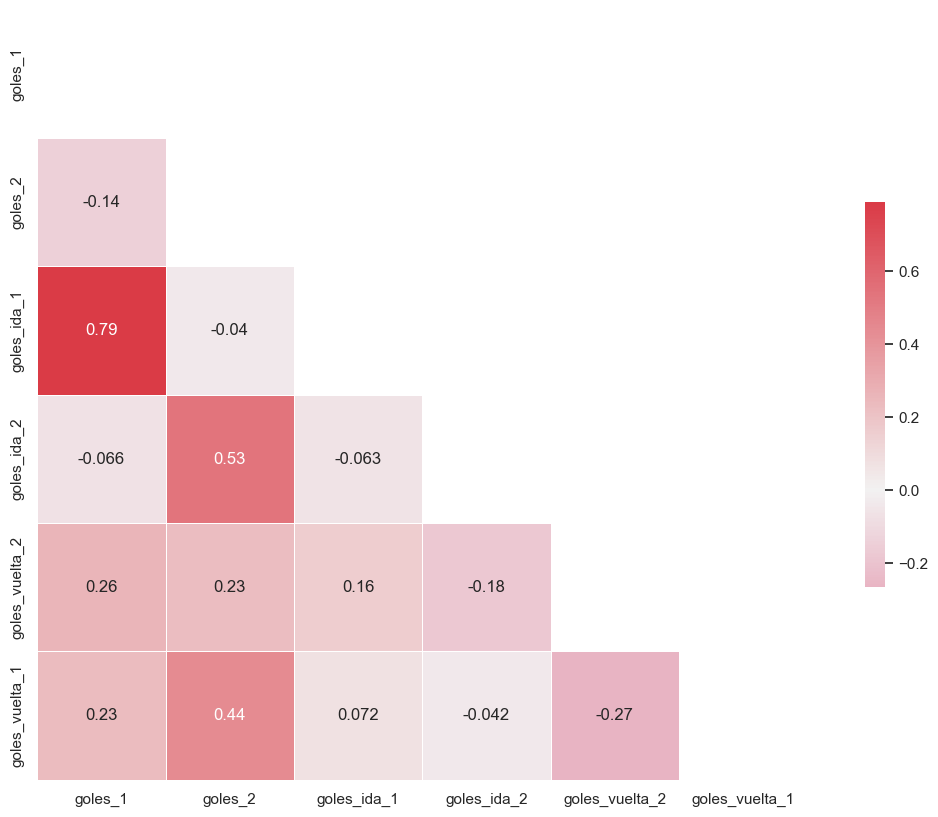

In [8]:
# Seleccionar solo las columnas numéricas
columnas_numericas = data.select_dtypes(include='number')

# Calcular la matriz de correlación
matriz_correlacion = columnas_numericas.corr()

# Crear el mapa de calor
plt.figure(figsize=(15, 10))
sns.set(style='white')

mask = np.triu(np.ones_like(matriz_correlacion, dtype=bool))
cmap = sns.diverging_palette(0, 10, as_cmap=True)

sns.heatmap(matriz_correlacion,
            mask=mask,
            cmap=cmap,
            center=0,
            square=True,
            annot=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.5})

plt.show()

